In [1]:
import pandas as pd
import json
import requests

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
METRICS_MIRCEA = 'code_smells,bugs,classes,lines,ncloc,sqale_index'
METRICS = METRICS_MIRCEA
SONARQUBE_IP = 'http://176.9.137.234'
SONARQUBE_PORT = '9000'
GITHUB_OWNER = 'apache'
GITHUB_REPO = 'maven'
SONARQUBE_PROJECT_KEY = GITHUB_OWNER + ':' + GITHUB_REPO
SONARQUBE_API_URL = SONARQUBE_IP + ':' + SONARQUBE_PORT + '/api/'
SONARQUBE_RESOURCE = 'resource=' + SONARQUBE_PROJECT_KEY
METRICS_LIST = METRICS.split(',')
PROJECT_KEYS = ['eclipse:egit-github','apache:maven','apache:hadoop']
metrics_list_length = len(METRICS_LIST)

In [4]:
response = requests.get(SONARQUBE_API_URL + 'timemachine?' + SONARQUBE_RESOURCE + '&metrics=' + METRICS)
json_data = json.loads(response.text)
cells = json_data[0]['cells']  # cells - metric values
cols = json_data[0]['cols']  # cols - Metrcs
no_of_commits = len(cells)

In [5]:
def get_project_dates(cells):
    dates = []
    for item in cells:
        dates.append(pd.Timestamp(item.get('d')))
    return dates

def get_max_project_date(cells):
    max_date = pd.Timestamp(cells[0].get('d'))
    for item in cells:
        current_date = pd.Timestamp(item.get('d'))
        if (current_date > max_date):
            max_date = current_date
    return max_date

def get_project_metrics(cells):
    df = pd.DataFrame(index=get_date_range_index(), columns=METRICS_LIST)
    for item in cells:
        for metric_index in range(0, metrics_list_length):
            df[METRICS_LIST[metric_index]][pd.Timestamp(item.get('d')).date()] = item.get('v')[metric_index]
    return df

def get_date_range_index():
    project_dates = get_project_dates(cells)
    min_project_date = min(project_dates)
    max_project_date = max(project_dates)
    return pd.date_range(start=min_project_date.date(), end=max_project_date.date(), freq='D')

def get_project_metricsBySeries(cells):
    date_range_index = get_date_range_index()
    df = pd.DataFrame(index=date_range_index)
    for metric_index in range(0, metrics_list_length):
        s = pd.Series(index=date_range_index)
        for item in cells:
            s[pd.Timestamp(item.get('d')).date()] = item.get('v')[metric_index]
        df[METRICS_LIST[metric_index]] = s
    return df

def plot_all(project_metrics):
    for metric_index in range(0, metrics_list_length):
        project_metrics[METRICS_LIST[metric_index]].plot()

In [6]:
project_metrics = get_project_metricsBySeries(cells)

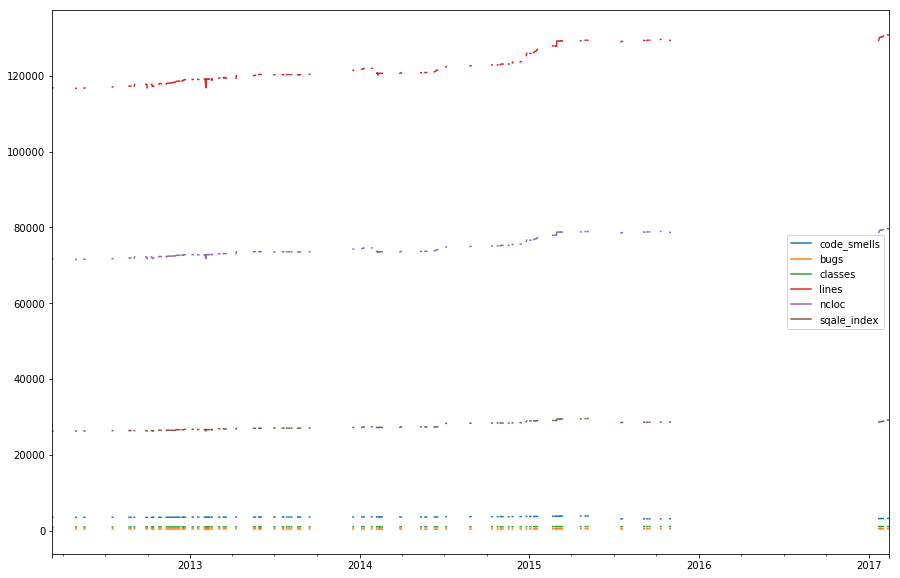

In [7]:
project_metrics.plot(figsize=(15, 10))

In [8]:
project_metrics.corr()

,code_smells,bugs,classes,lines,ncloc,sqale_index
code_smells,1.000000,-0.335765,-0.278455,-0.271765,-0.270685,0.013899
bugs,-0.335765,1.000000,0.538649,0.552311,0.568738,0.410729
classes,-0.278455,0.538649,1.000000,0.996488,0.993881,0.935146
lines,-0.271765,0.552311,0.996488,1.000000,0.999305,0.944126
ncloc,-0.270685,0.568738,0.993881,0.999305,1.000000,0.943995
sqale_index,0.013899,0.410729,0.935146,0.944126,0.943995,1.000000


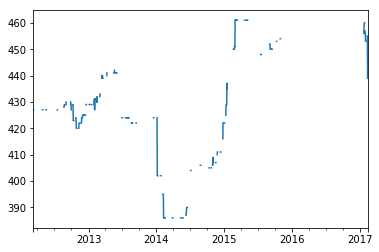

In [11]:
project_metrics['bugs'].plot()